# VGG-18: TensorFlow2 - Trained from Scratch using CIFAR-10

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, os, time
import math

from tqdm import tqdm
from tqdm import trange

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.layers import Layer, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal, Constant

# from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.6.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
# print(f"GPU: {gpu_devices}")

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: Quadro M6000


In [40]:
# Specify hyper-parameters
batch_size = 128
num_classes = 10
num_epochs = 75

weight_decay = 0.0005

In [6]:
# Data preprocessing and cleaning:
# input image dimensions
img_rows, img_cols = 32, 32

# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Load CIFAR-100 dataset-
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [7]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (32, 32, 3)



In [8]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [9]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [10]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 10)


### Prepare CIFAR10 dataset for TensorFlow _GradientTape_ training:

In [11]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2021-11-04 12:02:58.235048: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-04 12:02:59.658845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11491 MB memory:  -> device: 0, name: Quadro M6000, pci bus id: 0000:83:00.0, compute capability: 5.2
2021-11-04 12:03:02.683846: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.
2021-11-04 12:03:03.449628: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.
2021-11-04 12:03:04.038127: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of fre

In [12]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [13]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [14]:
# Choose loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
# optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)

In [15]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [16]:
class ConvBlock(Model):
    def __init__(self, num_filters, use_four_layers = False):
        super(ConvBlock, self).__init__()
        self.use_four_layers = use_four_layers
        
        self.conv1 = Conv2D(
            filters = num_filters, kernel_size = (3, 3),
            activation = None, kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            use_bias = False, kernel_regularizer = regularizers.l2(weight_decay)
        )
        self.bn1 = BatchNormalization(
            momentum = 0.99, epsilon = 0.001,
            beta_initializer = RandomNormal(mean = 0.0, stddev = 0.05),
            gamma_initializer = Constant(value = 0.9)
        )
        
        self.conv2 = Conv2D(
            filters = num_filters, kernel_size = (3, 3),
            activation = None, kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            use_bias = False, kernel_regularizer = regularizers.l2(weight_decay)
        )
        self.bn2 = BatchNormalization(
            momentum = 0.99, epsilon = 0.001,
            beta_initializer = RandomNormal(mean = 0.0, stddev = 0.05),
            gamma_initializer = Constant(value = 0.9)
        )
        
        if use_four_layers:
            self.conv3 = Conv2D(
                filters = num_filters, kernel_size = (3, 3),
                activation = None, kernel_initializer = tf.initializers.he_normal(),
                strides = (1, 1), padding = 'same',
                use_bias = False, kernel_regularizer = regularizers.l2(weight_decay)
            )
            self.bn3 = BatchNormalization(
                momentum = 0.99, epsilon = 0.001,
                beta_initializer = RandomNormal(mean = 0.0, stddev = 0.05),
                gamma_initializer = Constant(value = 0.9)
            )
            
            self.conv4 = Conv2D(
                filters = num_filters, kernel_size = (3, 3),
                activation = None, kernel_initializer = tf.initializers.he_normal(),
                strides = (1, 1), padding = 'same',
                use_bias = False, kernel_regularizer = regularizers.l2(weight_decay)
            )
            self.bn4 = BatchNormalization(
                momentum = 0.99, epsilon = 0.001,
                beta_initializer = RandomNormal(mean = 0.0, stddev = 0.05),
                gamma_initializer = Constant(value = 0.9)
            )
        
        self.pool = MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    
    
    def call(self, x):
        # x = tf.keras.activations.relu(self.bn1(self.conv1(x)))
        x = tf.nn.relu(self.bn1(self.conv1(x)))
        # x = tf.keras.activations.relu(self.bn2(self.conv2(x)))
        x = tf.nn.relu(self.bn2(self.conv2(x)))
        if self.use_four_layers:
            # x = tf.keras.activations.relu(self.bn3(self.conv3(x)))
            x = tf.nn.relu(self.bn3(self.conv3(x)))
            # x = tf.keras.activations.relu(self.bn4(self.conv4(x)))
            x = tf.nn.relu(self.bn4(self.conv4(x)))
            
        return self.pool(x)
    

In [17]:
class VGG18(Model):
    def __init__(self):
        super(VGG18, self).__init__()
        
        self.conv_block1 = ConvBlock(num_filters = 64, use_four_layers = False)
        self.conv_block2 = ConvBlock(num_filters = 128, use_four_layers = False)
        self.conv_block3 = ConvBlock(num_filters = 256, use_four_layers = True)
        self.conv_block4 = ConvBlock(num_filters = 512, use_four_layers = True)
        self.conv_block5 = ConvBlock(num_filters = 512, use_four_layers = True)
        self.flatten = Flatten()
        self.dense1 = Dense(
            units = 256, activation = 'relu',
            kernel_initializer = tf.initializers.he_normal(),
            use_bias = True, bias_initializer = 'ones'
        )
        self.out = Dense(
            units = 10, activation = 'softmax',
            use_bias = True, bias_initializer = 'ones'
        )
    
    
    def call(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.out(x)
        return x
    
    
    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x = Input(shape = (32, 32, 3))
        return Model(inputs = [x], outputs = self.call(x))
    
    

In [18]:
# Initialize a VGG-18 CNN architecture-
model = VGG18()
model.build(input_shape=(None, 32, 32, 3))

In [19]:
# Sanity check-
out = model(X_train[:batch_size, :])

2021-11-04 12:03:07.478142: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2021-11-04 12:03:08.492108: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-04 12:03:08.492544: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-04 12:03:08.492584: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-11-04 12:03:08.493402: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-04 12:03:08.493495: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [20]:
out.shape

TensorShape([128, 10])

In [21]:
del out

In [22]:
# Save current weights-
model.save_weights("VGG18_random_weights.h5", overwrite = True)

In [23]:
# model.load_weights("VGG18_random_weights.h5")

In [24]:
# Get CNN model summary-
model.model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_block (ConvBlock)       (None, 16, 16, 64)        39104     
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, 8, 8, 128)         222208    
_________________________________________________________________
conv_block_2 (ConvBlock)     (None, 4, 4, 256)         2068480   
_________________________________________________________________
conv_block_3 (ConvBlock)     (None, 2, 2, 512)         8265728   
_________________________________________________________________
conv_block_4 (ConvBlock)     (None, 1, 1, 512)         9445376   
_________________________________________________________________
flatten (Flatten)            (None, 512)               0     

In [25]:
# Count number of trainable parameters in VGG-18 model-
tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    print(f"layer: {layer.shape} has {loc_params} params")
    tot_params += loc_params

layer: (3, 3, 3, 64) has 1728 params
layer: (64,) has 64 params
layer: (64,) has 64 params
layer: (3, 3, 64, 64) has 36864 params
layer: (64,) has 64 params
layer: (64,) has 64 params
layer: (3, 3, 64, 128) has 73728 params
layer: (128,) has 128 params
layer: (128,) has 128 params
layer: (3, 3, 128, 128) has 147456 params
layer: (128,) has 128 params
layer: (128,) has 128 params
layer: (3, 3, 128, 256) has 294912 params
layer: (256,) has 256 params
layer: (256,) has 256 params
layer: (3, 3, 256, 256) has 589824 params
layer: (256,) has 256 params
layer: (256,) has 256 params
layer: (3, 3, 256, 256) has 589824 params
layer: (256,) has 256 params
layer: (256,) has 256 params
layer: (3, 3, 256, 256) has 589824 params
layer: (256,) has 256 params
layer: (256,) has 256 params
layer: (3, 3, 256, 512) has 1179648 params
layer: (512,) has 512 params
layer: (512,) has 512 params
layer: (3, 3, 512, 512) has 2359296 params
layer: (512,) has 512 params
layer: (512,) has 512 params
layer: (3, 3, 51

In [26]:
print(f"VGG-18 has {tot_params} trainable parameters")

VGG-18 has 20163784 trainable parameters


In [27]:
import tensorflow.keras.backend as K


# METHOD-1: This also counts biases
trainable_wts = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_wts = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print("\nNumber of training weights = {0} and non-trainabel weights = {1}\n".format(
    trainable_wts, non_trainable_wts
))
print("Total number of parameters = {0}\n".format(trainable_wts + non_trainable_wts))



Number of training weights = 20163786 and non-trainabel weights = 11008

Total number of parameters = 20174794



In [28]:
print("\nAccording to tf.keras.backend: Number of training weights = {0}, non-trainabel weights = {1} and total number of parameters = {2}\n".format(
    trainable_wts, non_trainable_wts, (trainable_wts + non_trainable_wts)
))

print("According to tf.math.count_nonzero() method, total number of trainable weights = {0}\n".format(tot_params))


According to tf.keras.backend: Number of training weights = 20163786, non-trainabel weights = 11008 and total number of parameters = 20174794

According to tf.math.count_nonzero() method, total number of trainable weights = 20163784



### Image Augmentation using _ImageDataGenerator_:

Refer-
[tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [29]:
# Example of using 'tf.keras.preprocessing.image import ImageDataGenerator class's - flow(x, y)':
datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range = 15,
    width_shift_range = 0.1, # 0.2
    height_shift_range = 0.1, # 0.2
    horizontal_flip = True
)


# flow():
# Takes data & label arrays, generates batches of augmented data.

# datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)

In [30]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

In [31]:
# Create mask for original, unpruned model-
mask_model = VGG18()
mask_model.build(input_shape = (None, 32, 32, 3))

In [32]:
# Assign all masks to one-
for wts in mask_model.trainable_weights:
    wts.assign(
        tf.ones_like(input = wts, dtype = tf.float32
                    )
    )

In [33]:
# Sanity check-
mask_params = 0

for layer in mask_model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    mask_params += loc_params
    
print("\nVGG-18 number of non-zero masks = {0}\n".format(mask_params))


VGG-18 number of non-zero masks = 20163786



In [34]:
mask_params == tot_params

False

In [35]:
def count_params(model):
    model_sum_params = 0

    for layer in model.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    return model_sum_params
    

In [36]:
# Sanity check-
print(f"VGG-18 has {count_params(model)} trainable parameters")

VGG-18 has 20163784 trainable parameters


### Learning rate warmup:

Using a large learning rate may result in numerical instability especially at the very beginning of training where parameters are randomly initialized. The warmup strategy increases the learning rate from 0 to the initial learning rate linearly during the initial __N__ epochs or __m__ batches.

Even though Keras already came with the _LearningRateScheduler_ capable of updating the learning rate for each training epoch, in order to achieve finer updates for each batch, the following code is how you can implement a custom Keras callback to do that.

In [37]:
from typing import Callable, List, Optional, Union

In [38]:
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Applies a warmup schedule on a given learning rate decay schedule.

    Args:
        initial_learning_rate (:obj:`float`):
            The initial learning rate for the schedule after the warmup (so this will be the learning rate at the end
            of the warmup).
            
        decay_schedule_fn (:obj:`Callable`):
            The schedule function to apply after the warmup for the rest of training.
        
        warmup_steps (:obj:`int`):
            The number of steps for the warmup part of training.
        
        power (:obj:`float`, `optional`, defaults to 1):
            The power to use for the polynomial warmup (defaults is a linear warmup).
        
        name (:obj:`str`, `optional`):
            Optional name prefix for the returned tensors during the schedule.
    """

    def __init__(
        self,
        initial_learning_rate: float,
        decay_schedule_fn: Callable,
        warmup_steps: int,
        power: float = 1.0,
        name: str = None,
    ):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.power = power
        self.decay_schedule_fn = decay_schedule_fn
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "WarmUp") as name:
            # Implements polynomial warmup. i.e., if global_step < warmup_steps, the
            # learning rate will be `global_step/num_warmup_steps * init_lr`.
            global_step_float = tf.cast(step, tf.float32)
            warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
            warmup_percent_done = global_step_float / warmup_steps_float
            warmup_learning_rate = self.initial_learning_rate * tf.math.pow(warmup_percent_done, self.power)
            return tf.cond(
                global_step_float < warmup_steps_float,
                lambda: warmup_learning_rate,
                lambda: self.decay_schedule_fn(step - self.warmup_steps),
                name=name,
            )

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "decay_schedule_fn": self.decay_schedule_fn,
            "warmup_steps": self.warmup_steps,
            "power": self.power,
            "name": self.name,
        }
    

In [39]:
print(f"CIFAR-10: Using a batch size of {batch_size} gives {len(X_train) / batch_size} training steps")

CIFAR-10: Using a batch size of 128 gives 390.625 training steps


### Train model with _learning rate scheduler_

Training dataset = 50000, batch size = 128, number of training steps or,iterations = 50000 / 128 = 390.625 = 391

__After an initial linear learning rate warmup of 10 epochs or 3907 training steps:__

- For the next 11718.75 = 11718 training steps or 30 epochs - until 40th epoch, use learning rate = 0.1

- For the next 7812.5 = 7813 training steps or 20 epochs - until 60th epoch, use learning rate = 0.01

- For the next 3906.25 = 3907 training steps or 10 epochs - until 70th epoch, use learning rate = 0.001

- For the last 5 epochs, use learning rate = 0.0001

In [41]:
boundaries = [11718, 19531, 23438]
values = [0.1, 0.01, 0.001, 0.0001]

#### tf.keras.optimizers.schedules.PiecewiseConstantDecay

A LearningRateSchedule that uses a piecewise constant decay schedule. Inherits From: ```LearningRateSchedule```

```
tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values, name=None
)
```

The function returns a 1-arg callable to compute the piecewise constant when passed the current optimizer step. This can be useful for changing the learning rate value across different invocations of optimizer functions.

Example: use a learning rate that's 1.0 for the first 100001 steps, 0.5 for the next 10000 steps, and 0.1 for any additional steps.
```
step = tf.Variable(0, trainable=False)
boundaries = [100000, 110000]
values = [1.0, 0.5, 0.1]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
learning_rate = learning_rate_fn(step)
```

You can pass this schedule directly into a tf.keras.optimizers.Optimizer as the learning rate. The learning rate schedule is also serializable and deserializable using ```tf.keras.optimizers.schedules.serialize``` and ```tf.keras.optimizers.schedules.deserialize```.


__Returns__
A 1-arg callable learning rate schedule that takes the current optimizer step and outputs the decayed learning rate, a scalar Tensor of the same type as the boundary tensors.

The output of the 1-arg function that takes the ```step``` is ```values[0]``` when ```step <= boundaries[0]```, ```values[1]``` when ```step > boundaries[0]``` and ```step <= boundaries[1]```, ..., and ```values[-1] when step > boundaries[-1]```.

[tf.keras.optimizers.schedules.PiecewiseConstantDecay ](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PiecewiseConstantDecay)

In [42]:
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

In [43]:
# warmup_shcedule = WarmUp(initial_learning_rate = 0.1, decay_schedule_fn = learning_rate_fn, warmup_steps = 7813)
warmup_shcedule = WarmUp(initial_learning_rate = 0.1, decay_schedule_fn = learning_rate_fn, warmup_steps = 3906)

In [44]:
optimizer = tf.keras.optimizers.SGD(learning_rate = warmup_shcedule, momentum = 0.9, decay = 0.0, nesterov = False)

### Train model using _tf.GradientTape_:

In [ ]:
# User input parameters for Early Stopping in manual implementation-
# minimum_delta = 0.001
# patience = 3

In [45]:
best_val_loss = 100
# loc_patience = 0

In [46]:
# Define 'train_one_step()' and 'test_step()' functions here-
@tf.function
def train_one_step(model, mask_model, optimizer, x, y):
    '''
    Function to compute one step of gradient descent optimization
    '''
    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        y_pred = model(x)

        # Compute loss-
        loss = loss_fn(y, y_pred)
        
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    # List to hold element-wise multiplication between-
    # computed gradient and masks-
    grad_mask_mul = []
    
    # Perform element-wise multiplication between computed gradients and masks-
    for grad_layer, mask in zip(grads, mask_model.trainable_weights):
        grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

    # Compute accuracy-
    train_loss(loss)
    train_accuracy(y, y_pred)

    return None


In [47]:
@tf.function
def test_step(model, optimizer, data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

    return None


In [48]:
# Python3 dict to contain model training metrics-
history_lr = {}

In [49]:
print(f"VGG-18 will be trained for {num_epochs} epochs in total")

VGG-18 will be trained for 75 epochs in total


In [50]:
# Train model using 'GradientTape'-
    
# Initialize parameters for Early Stopping manual implementation-
# best_val_loss = 100
# loc_patience = 0
    
for epoch in range(num_epochs):
    '''
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    '''
    
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    # variable to keep track of current training step-
    curr_step = 0
    
    # Train using data augmentation (ImageDataGenerator())-
    for x, y in datagen.flow(X_train, y_train, batch_size = batch_size, shuffle = True):
        train_one_step(model, mask_model, optimizer, x, y)
        # print("current step = ", curr_step)
        curr_step += 1
        
        # break out of infinite loop to end current training epoch-
        if curr_step >= X_train.shape[0] // batch_size:
            # print("\nTerminating training (datagen.flow())")
            break

    # Testing dataset-
    for x_t, y_t in test_dataset:
        test_step(model, optimizer, x_t, y_t)
    
    print(f"\nEpoch = {epoch + 1}; loss = {train_loss.result().numpy():.4f}, accuracy = {train_accuracy.result().numpy() * 100:.3f}%",
          f" val loss = {test_loss.result().numpy():.4f}, val acc = {test_accuracy.result().numpy() * 100:.3f}%"
          f" LR = {optimizer._decayed_lr('float32').numpy():.6f} & step_val = {optimizer.iterations.numpy()}"
         )
    
    history_lr[epoch + 1] = {
        'loss': train_loss.result().numpy(), 'acc': train_accuracy.result().numpy() * 100,
        'val_loss': test_loss.result().numpy(), 'val_acc': test_accuracy.result().numpy() * 100,
        'lr': optimizer._decayed_lr('float32').numpy(), 'step_val': optimizer.iterations.numpy()
    }

    # Count number of non-zero parameters in each layer and in total-
    print(f"VGG-18: total # of trainable parameters = {count_params(model)}")
    
    # Insert manual implementation of code for early stopping here.
    
    
    # Save best weights achieved until now-
    if (test_loss.result() < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = test_loss.result()
        
        print(f"Saving model with lowest val_loss = {test_loss.result():.4f}\n")
        
        # Save trained model with validation accuracy-
        model.save_weights("VGG18_best_trained_loss.h5", overwrite = True)
   

2021-11-04 12:08:11.324558: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-04 12:09:07.169455: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.



Epoch = 1; loss = 2.1001, accuracy = 22.318%  val loss = 1.7824, val acc = 34.260% LR = 0.009985 & step_val = 390
VGG-18: total # of trainable parameters = 20163786
Saving model with lowest val_loss = 1.7824


Epoch = 2; loss = 1.6431, accuracy = 38.674%  val loss = 1.5187, val acc = 43.740% LR = 0.019969 & step_val = 780
VGG-18: total # of trainable parameters = 20163786
Saving model with lowest val_loss = 1.5187


Epoch = 3; loss = 1.4218, accuracy = 48.405%  val loss = 1.2623, val acc = 54.350% LR = 0.029954 & step_val = 1170
VGG-18: total # of trainable parameters = 20163786
Saving model with lowest val_loss = 1.2623


Epoch = 4; loss = 1.2521, accuracy = 55.104%  val loss = 1.0950, val acc = 62.010% LR = 0.039939 & step_val = 1560
VGG-18: total # of trainable parameters = 20163786
Saving model with lowest val_loss = 1.0950


Epoch = 5; loss = 1.1407, accuracy = 60.353%  val loss = 0.9291, val acc = 68.150% LR = 0.049923 & step_val = 1950
VGG-18: total # of trainable parameters = 

In [52]:
model.save_weights("VGG18_best_trained_weights.h5", overwrite = True)

In [51]:
print("\nFinished training VGG-18 CNN\n")


Finished training VGG-18 CNN



In [51]:
history_lr.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])

In [52]:
history_lr[10].keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr', 'step_val'])

In [53]:
history_lr[10]['val_acc'], history_lr[10]['acc']

(74.15000200271606, 72.41185903549194)

In [54]:
history_lr[10]['loss'], history_lr[10]['val_loss']

(0.84050053, 0.8614807)

In [55]:
history_lr[10]['lr']

0.099846385

In [53]:
import pickle

with open("VGG18_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(history_lr, file)


In [ ]:
# Initialize & load best weights model-
best_model = VGG18()
best_model.build(input_shape = (None, 32, 32, 3))

best_model.load_weights("VGG18_best_trained_loss.h5")

In [ ]:
# Compile model-
best_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.SGD(learning_rate = warmup_shcedule, momentum = 0.9, decay = 0.0, nesterov = False),
    # optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9),
    metrics=['accuracy']
)

In [ ]:
# Evaluate trained model's validation loss and validation accuracy on validation dataset-
loss, acc = best_model.evaluate(X_test, y_test, verbose = 0)

In [ ]:
print("\nTrained VGG-18 CNN model metrics on validation dataset:")
print(f"loss = {loss:.4f} & accuracy = {acc * 100:.2f}%")


Trained VGG-18 CNN model metrics on validation dataset:
loss = 14.7462 & accuracy = 90.02%


### Visualizations:

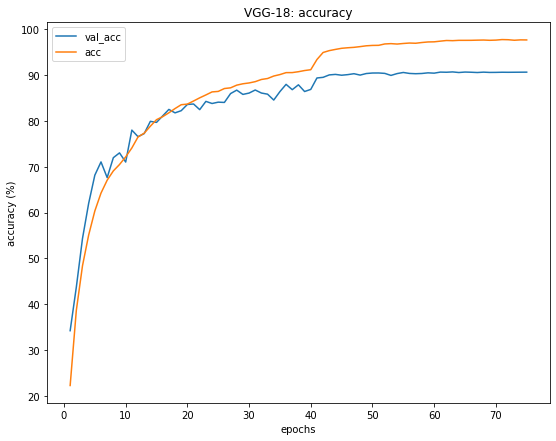

In [54]:
# Visualize accuracies-
plt.figure(figsize = (9, 7))
plt.plot(list(history_lr.keys()), [history_lr[x]['val_acc'] for x in history_lr.keys()], label = 'val_acc')
plt.plot(list(history_lr.keys()), [history_lr[x]['acc'] for x in history_lr.keys()], label = 'acc')
plt.title("VGG-18: accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

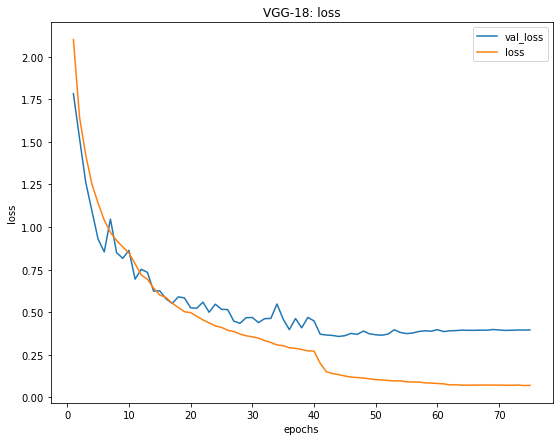

In [55]:
# Visualize losses-
plt.figure(figsize = (9, 7))
plt.plot(list(history_lr.keys()), [history_lr[x]['val_loss'] for x in history_lr.keys()], label = 'val_loss')
plt.plot(list(history_lr.keys()), [history_lr[x]['loss'] for x in history_lr.keys()], label = 'loss')
plt.title("VGG-18: loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.show()

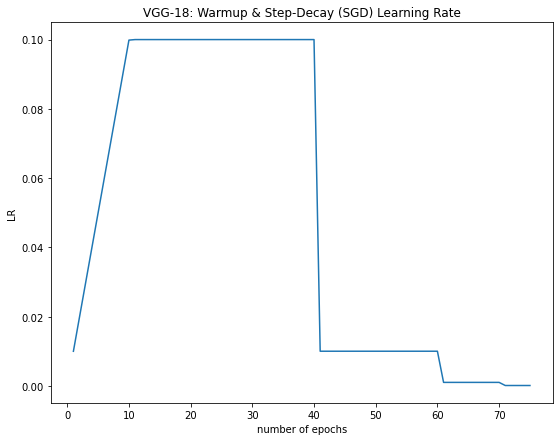

In [56]:
# Visualize learning rate during training-
plt.figure(figsize = (9, 7))
plt.plot(list(history_lr.keys()), [history_lr[x]['lr'] for x in history_lr.keys()])
plt.title("VGG-18: Warmup & Step-Decay (SGD) Learning Rate")
plt.xlabel("number of epochs")
plt.ylabel("LR")
plt.show()